In [1]:
import tensorflow as tf

# Basic Neural Networks with TF

Constructing a neural network in TF low level python API allows you to create your own layers as functions to be combined in flexible ways. 


### Load the data

In [2]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.cross_validation import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

def normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean) / std

### Normalize and split the data

In [3]:
housing = fetch_california_housing()

# load the data into numpy arrays
housing_features = housing.data
housing_targets = housing.target

n, f_dim = housing_features.shape

# normalize the features
housing_features= normalize(housing_features)

# add bias
housing_features = np.c_[np.ones((n, 1)), housing_features]

housing_features = housing_features[housing_targets < 5]
housing_targets = housing_targets[housing_targets < 5]

# reshape targets to TF expectation
housing_targets = np.expand_dims(housing_targets, 1)

X_train, X_test, y_train, y_test = train_test_split(housing_features,
                                                    housing_targets,
                                                    test_size=0.1)

print(housing.feature_names)
print(X_train.shape)
print(y_train.shape)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
(17683, 9)
(17683, 1)


### Set up Neural Network Hyperparameters

LR, EPOCHS, BATCHSIZE, and n_hidden are all parameters that you can play with to acheive the best performance.

In [4]:
LR = 0.01
EPOCHS = 200
BATCHSIZE = 32
n_inputs = 8
n_hidden = 32
n_output = 1

Since we will be training this network with mini-batch gradient descent we need to set up tensorflow placeholders for our input and target data. The place holders serve as buckets in our graph that we can place data into during training. We need only to define the shape of the data with respect to the feature dimensions. The `None` serves as a wildcard for the batchsize, having `None` there allows us to use any batch size that we choose during training.

In [5]:
X = tf.placeholder(tf.float32, shape=(None, f_dim+1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')

# Exercise

Build your own generic dense layer function. 

The following code block should create a dense neural network layer. First start with a named scope, this allows the arbitrary blocks/layers to be stacked up with unique names in the TF graph. Then initialize the weights of the layers using the [He normal initialization method](https://arxiv.org/pdf/1502.01852.pdf).

```python
stddev = 2 / np.sqrt(n_inputs + n_units)
init = tf.truncated_normal((n_inputs, n_units), stddev=stddev)
```

Then we set up the weight matrix and bias vector.

Finall, we compute the linear combination of the weight vector, input data and bais vector. Passing that through an activation function if that were provided.

### Solution

In [6]:
def dense_layer(X, n_units, name, activation=None):
    '''
    Sets up a hidden layer to be used to build a multilayer perceptron. 
    
    Initializes the weights of the neurons using a normal distribution with
    standard deviation equal to 2 / sqrt(input_dimension + number_neurons)
    
    Parameters:
    X: input data for the layer
    n_units: number of neurons to use in the layer
    name: the name of the scope to be used with this layer
    activation: the tensorflow nonlinearity to be used for each neuron
    
    Returns:
    Tensorflow graph description representing the constructed layer
    '''
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_units)
        init = tf.truncated_normal((n_inputs, n_units), stddev=stddev)
        W = tf.Variable(init, name='hidden_weights')
        b = tf.Variable(tf.zeros([n_units]), name='bias')
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

Creating a neural network from this layer definition is fairly straight forward now. We essentially just create a new named scope and stack two of our newly created layers together with the desired parameters. If we wanted more layers we would simply just add more to the center of our network definition.

We will also create TF scopes for the loss and SGD functions, a slight twist on what we did before but the functionality is the same.

In [7]:
# build the network using the hidden layer function
with tf.name_scope('dnn'):
    hidden = dense_layer(X, n_hidden, name='hidden_layer', activation=tf.nn.relu)
    y_pred = dense_layer(hidden, 1, name='output')
    
with tf.name_scope('loss'):
    error = y_pred - y
    loss = tf.reduce_mean(tf.square(error), name='mse')
    
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(LR).minimize(loss)

Train the network using mini-batch gradient descent. We will slice up our training data into batches of size `BATCHSIZE` and feed each batch into the network in succession. Just like we did with the linear model in the previous notebook, but with smaller portions of the dataset for each step rather than the whole thing. 

In [8]:
saver = tf.train.Saver()
init = tf.global_variables_initializer()

losses = []
n_samples = X_train.shape[0]
with tf.Session() as sess:
    sess.run(init)
    
    for e in range(EPOCHS):
        if e % 10 == 0:
            print("Epoch:", e, 
                  "Current loss:", 
                  sess.run(loss, feed_dict={X: X_train, y: y_train}), 
                  "Test loss:",
                  sess.run(loss, feed_dict={X: X_test, y: y_test}))
            
        for i in range((n_samples + BATCHSIZE - 1) // BATCHSIZE):
            sl = slice(i * BATCHSIZE, (i+1) * BATCHSIZE)
            X_b = X_train[sl]
            y_b = y_train[sl]
            sess.run(train_step, feed_dict={X: X_b, y: y_b})
            losses.append(sess.run(loss, feed_dict={X: X_b, y: y_b}))
        
    save_path = saver.save(sess, '/tmp/mlp_regression.ckpt')

Epoch: 0 Current loss: 8.96931 Test loss: 9.05108
Epoch: 10 Current loss: 0.282224 Test loss: 0.308655
Epoch: 20 Current loss: 0.264335 Test loss: 0.290813
Epoch: 30 Current loss: 0.255238 Test loss: 0.284554
Epoch: 40 Current loss: 0.250484 Test loss: 0.28084
Epoch: 50 Current loss: 0.245575 Test loss: 0.276698
Epoch: 60 Current loss: 0.243496 Test loss: 0.27557
Epoch: 70 Current loss: 0.240772 Test loss: 0.273608
Epoch: 80 Current loss: 0.23849 Test loss: 0.272367
Epoch: 90 Current loss: 0.237061 Test loss: 0.26897
Epoch: 100 Current loss: 0.23546 Test loss: 0.267746
Epoch: 110 Current loss: 0.23509 Test loss: 0.268516
Epoch: 120 Current loss: 0.23458 Test loss: 0.269077
Epoch: 130 Current loss: 0.233464 Test loss: 0.267675
Epoch: 140 Current loss: 0.2332 Test loss: 0.266806
Epoch: 150 Current loss: 0.232604 Test loss: 0.266697
Epoch: 160 Current loss: 0.231892 Test loss: 0.265781
Epoch: 170 Current loss: 0.231398 Test loss: 0.26506
Epoch: 180 Current loss: 0.231036 Test loss: 0.2639

Load the saved model and make predictions on the test set.

In [9]:
# best weight values are saved in the checkpoint
with tf.Session() as sess:
    saver.restore(sess, '/tmp/mlp_regression.ckpt')
    preds = sess.run(y_pred, feed_dict={X: X_test})
    print(sess.run(loss, feed_dict={X: X_test, y: y_test}))

INFO:tensorflow:Restoring parameters from /tmp/mlp_regression.ckpt
0.261601


We did better than the simple linear regression from the previous example.

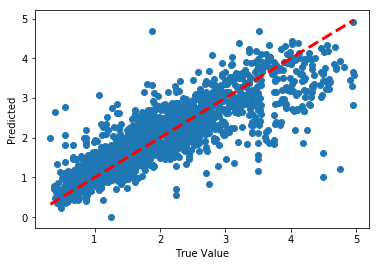

In [10]:
fig, ax = plt.subplots()
ax.scatter(y_test, preds)
ax.plot([y_test.min(), y_test.max()], 
        [y_test.min(), y_test.max()], '--', lw=3, color='r')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted')
plt.show()